In [1]:
!pip install torch torchvision matplotlib
!pip install kaggle
from google.colab import files
files.upload()
#setting up kaggle API credentials
#prompts user to upload their json file with their credentials

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"damianosorio","key":"6778c9af13f45de75972aafd40a4e9ee"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip -d chest_xray
#download and extract the pneumonia dataset from the kaggle api

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [4]:
!ls /content/chest_xray
!ls /content/chest_xray/chest_xray
#check the directory/file path

chest_xray
chest_xray  __MACOSX  test  train  val


In [5]:

import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import  confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torchvision.models import GoogLeNet_Weights
from torch.utils.data import DataLoader
import os
import seaborn as sns
import matplotlib.pyplot as plt
#import neccessary libraries


In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
#set variables regarding batch size, img size and the set number of epochs

In [7]:
#define the paths needed for each dataset: training, validation, and testing
train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'


#define data transformations
#img size is 224 x 224, for googLeNet
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#resizing of images to GoogLeNet size or 224 x 224
#convert images to tensors
#normalize the images using mean values and std values

#load images from the directories
train_ds = datasets.ImageFolder(train_dir, transform=train_transforms)
val_ds = datasets.ImageFolder(val_dir, transform=val_transforms)
test_ds = datasets.ImageFolder(test_dir, transform=val_transforms)

#creation of dataloaders to iterate through them in batches
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print("Train dataset size:", len(train_ds))
print("Validation dataset size:", len(val_ds))
print("Test dataset size:", len(test_ds))
print(train_ds.class_to_idx)
#making sure that the dataset is the correct size, just to double check
#model assigns values to dataset due to the imbalance of normal to pneumonia images


Train dataset size: 5216
Validation dataset size: 16
Test dataset size: 624
{'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
#load a pretrained GoogLeNet model
googlenet = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)

#modified the final layer for binary classification pnuemonia: 1, normal: 0 as the model determined it to be
googlenet.fc = nn.Linear(googlenet.fc.in_features, 2)

#set the model to gpu if it is available
#I ran the model strictly on cpu before I learned that I can simulate a gpu on google colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 108MB/s]


In [9]:
normal_ctr = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_ctr = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))

weights = torch.tensor([1.0/normal_ctr, 1.0/pneumonia_ctr], device = device)

criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)
#define the loss function and optimizer in order to update model parameters


Epoch 1/10
Train Loss: 0.1485
Val Loss: 1.1581 | Val Acc: 0.6250 | Val Precision: 0.5714 | Val F1: 0.7273
Epoch 2/10
Train Loss: 0.0881
Val Loss: 0.3584 | Val Acc: 0.9375 | Val Precision: 0.8889 | Val F1: 0.9412
Epoch 3/10
Train Loss: 0.0883
Val Loss: 1.7466 | Val Acc: 0.5625 | Val Precision: 0.5333 | Val F1: 0.6957
Epoch 4/10
Train Loss: 0.0724
Val Loss: 1.0248 | Val Acc: 0.6250 | Val Precision: 0.5714 | Val F1: 0.7273
Epoch 5/10
Train Loss: 0.0595
Val Loss: 0.0920 | Val Acc: 1.0000 | Val Precision: 1.0000 | Val F1: 1.0000
Epoch 6/10
Train Loss: 0.0662
Val Loss: 0.2853 | Val Acc: 0.9375 | Val Precision: 0.8889 | Val F1: 0.9412
Epoch 7/10
Train Loss: 0.0533
Val Loss: 0.0585 | Val Acc: 1.0000 | Val Precision: 1.0000 | Val F1: 1.0000
Epoch 8/10
Train Loss: 0.0559
Val Loss: 0.0703 | Val Acc: 1.0000 | Val Precision: 1.0000 | Val F1: 1.0000
Epoch 9/10
Train Loss: 0.0376
Val Loss: 0.1020 | Val Acc: 0.9375 | Val Precision: 1.0000 | Val F1: 0.9333
Epoch 10/10
Train Loss: 0.0504
Val Loss: 0.224

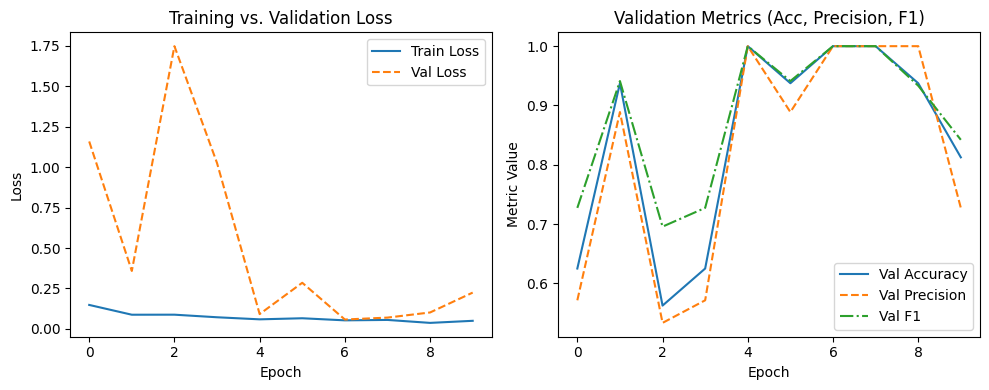

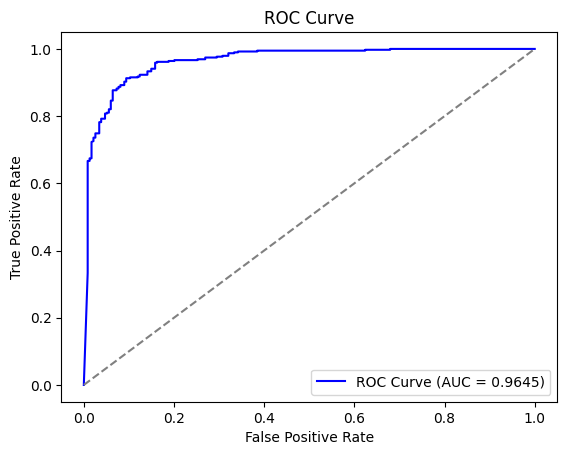

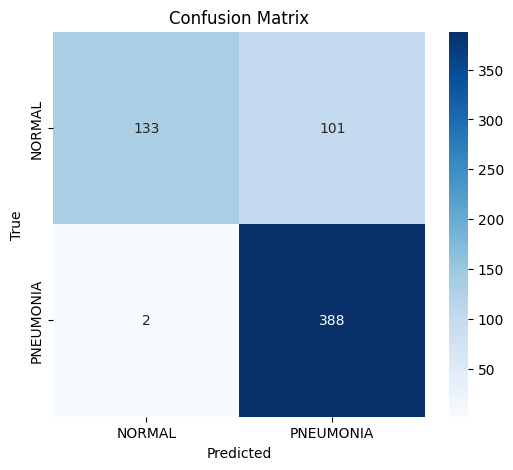

In [10]:
def evaluate_metrics(model, data_loader, criterion):
    #evaluate the model and return loss, accuracy, precision, recall, and f1-score
    model.eval()
    all_labels = []
    all_preds = []
    loss = 0.0
    #sets the model into evaluation mode
    #stores data using the lists

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            batch_loss = criterion(outputs, labels).item()
            loss += batch_loss
            #iterates through data loader, moves images and labels to correct device
            #i used cpu only, then simulated gpu performance
            #forward pass to compute batch loss

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            #get the predictions, collect all labels and predictions for metric computation

    avg_loss = loss / len(data_loader)
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return avg_loss, acc, precision, recall, f1
    #calculate avg loss and calculate the evaluation metrics

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    #Train model while using f1 score as main metric, track accuracy and precision
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_f1s = []
    #lists to store the metrics needed for training and validation

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_samples = 0
        #sets the model up ready for training

        #conditional for training
        #move images to correct device
        #zero out gradients from the previous step
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #forward pass
            #calculate loss
            #backward pass to optimize

            running_loss += loss.item() * images.size(0)
            total_samples += labels.size(0)
            #accumulate loss and sample count

        avg_train_loss = running_loss / total_samples
        train_losses.append(avg_train_loss)
        #calculate average training loss

        #evaluate the model on the validation set
        val_loss, val_acc, val_prec, val_recall, val_f1 = evaluate_metrics(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_precisions.append(val_prec)
        val_f1s.append(val_f1)

        #print the metrics for current epoch, again focusing on the f1 score
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Precision: {val_prec:.4f} | Val F1: {val_f1:.4f}")

    return train_losses, val_losses, val_accuracies, val_precisions, val_f1s

#train model
train_losses, val_losses, val_accuracies, val_precisions, val_f1s = train_model(googlenet, train_loader, val_loader, criterion, optimizer, epochs=10)

#evaluate the test set
test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate_metrics(googlenet, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} | Test Precision: {test_prec:.4f} | Test F1: {test_f1:.4f}")

#plot the Training vs. Validation Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss', linestyle='--')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#plot Validation Accuracy, Precision, and F1-score
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.plot(val_precisions, label='Val Precision', linestyle='--')
plt.plot(val_f1s, label='Val F1', linestyle='-.')
plt.title("Validation Metrics (Acc, Precision, F1)")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.legend()
plt.tight_layout()
plt.show()

#calculate probabilities for ROC
googlenet.eval()
all_labels = []
all_scores = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = googlenet(images)
        probs = nn.Softmax(dim=1)(outputs)
        pneumonia_probs = probs[:, 1].cpu().numpy()
        #iterate through test loader
        #same forward pass method as used above
        #apply softmax to get the class probabilities

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(pneumonia_probs)
        all_preds.extend(preds.cpu().numpy())
        #get the predictions

#ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes
#as model mentioned earlier, normal = 0, pneumonia = 1 because of imbalance
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

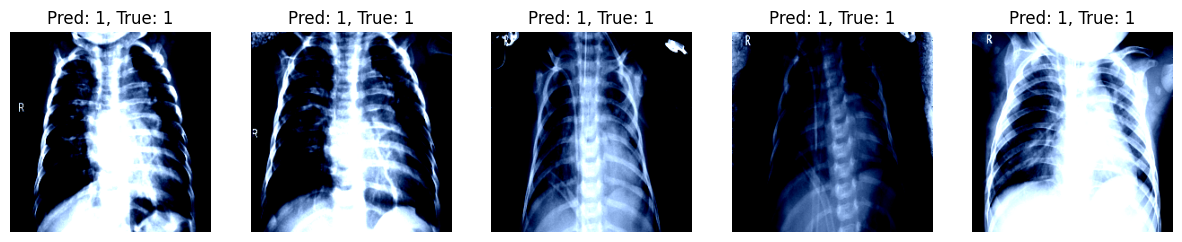

In [14]:


def visualize_predictions(model, data_loader, num_images = 5):
    model.eval()
    all_batches = list(data_loader)
    images, labels = random.choice(all_batches)

    #visualize predictions for 5 images on the dataset

    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)



    #display images along with model predictions, and their true labels
    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3 ))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().permute(1, 2, 0))
        ax.set_title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
        ax.axis('off')
        #conversion from pytorch tensor to a format suitable for plotting using pyplotlib

visualize_predictions(googlenet, test_loader)
#visualize model predictions